In [1]:
import osmnx as ox
import geopandas as gpd
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from matplotlib.colors import LinearSegmentedColormap
from rasterio.features import rasterize
import numpy as np

In [2]:
location_point = (34.138434, -118.124650)
distance = 1000
buildings = ox.geometries.geometries_from_point(location_point, tags={'building': True}, dist=distance)
streets = ox.graph_from_point(location_point, dist=distance, network_type='drive')
streets_gdf = ox.graph_to_gdfs(streets, nodes=False, edges=True)

/var/folders/pv/vxz_z6x905j13byjd_vxl_br0000gn/T/ipykernel_48012/1410458675.py:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  buildings = ox.geometries.geometries_from_point(location_point, tags={'building': True}, dist=distance)


In [2]:
streets_gdf

osmid  \
u           v         key                                                 
20827732    123311320 0                                        13397626   
            583031056 0    [405378336, 405378385, 405378461, 405378375]   
            122487928 0                          [405378426, 405378379]   
20827733    122779084 0                                        13313070   
            122707096 0               [405328864, 405328869, 405328918]   
...                                                                 ...   
10769222482 123013699 0               [405367273, 405367300, 405367310]   
            123143339 0                                      1189215644   
11362350971 745919292 0                                        13418780   
            674744937 0                                       522088015   
            122615444 0                                       522088015   

                                                name      highway  oneway  \
u           v         key                                                   
20827732    123311320 0          South Bonnie Avenue  residential   False   
            583031056 0      East Colorado Boulevard      primary   False   
            122487928 0      East Colorado Boulevard      primary   False   
20827733    122779084 0        South Catalina Avenue  residential   False   
            122707096 0      East Colorado Boulevard      primary   False   
...                                              ...          ...     ...   
10769222482 123013699 0    East California Boulevard     tertiary   False   
            123143339 0                   Arden Road  residential   False   
11362350971 745919292 0                   Arden Road  residential   False   
            674744937 0       South Oak Knoll Avenue  residential   False   
            122615444 0       South Oak Knoll Avenue  residential   False   

                           reversed   length  \
u           v         key                      
20827732    123311320 0       False  452.963   
            583031056 0       False  116.890   
            122487928 0        True  120.736   
20827733    122779084 0       False  148.925   
            122707096 0       False  124.206   
...                             ...      ...   
10769222482 123013699 0       False  287.679   
            123143339 0        True  195.883   
11362350971 745919292 0       False  134.429   
            674744937 0       False  122.380   
            122615444 0        True  119.866   

                                                                    geometry  \
u           v         key                                                      
20827732    123311320 0    LINESTRING (-118.11575 34.14601, -118.11574 34...   
            583031056 0    LINESTRING (-118.11575 34.14601, -118.11562 34...   
            122487928 0    LINESTRING (-118.11575 34.14601, -118.11587 34...   
20827733    122779084 0    LINESTRING (-118.12940 34.14592, -118.12940 34...   
            122707096 0    LINESTRING (-118.12940 34.14592, -118.12932 34...   
...                                                                      ...   
10769222482 123013699 0    LINESTRING (-118.12440 34.13590, -118.12431 34...   
            123143339 0    LINESTRING (-118.12440 34.13590, -118.12440 34...   
11362350971 745919292 0    LINESTRING (-118.13459 34.13181, -118.13446 34...   
            674744937 0    LINESTRING (-118.13459 34.13181, -118.13457 34...   
            122615444 0    LINESTRING (-118.13459 34.13181, -118.13462 34...   

                                      ref   lanes maxspeed  
u           v         key                                   
20827732    123311320 0               NaN     NaN      NaN  
            583031056 0    US 66 HISTORIC     NaN      NaN  
            122487928 0    US 66 HISTORIC     NaN      NaN  
20827733    122779084 0               NaN     NaN      NaN  
            122707096 0    US 66 HISTORIC  [4, 5]      N

Raster CRS: EPSG:32611


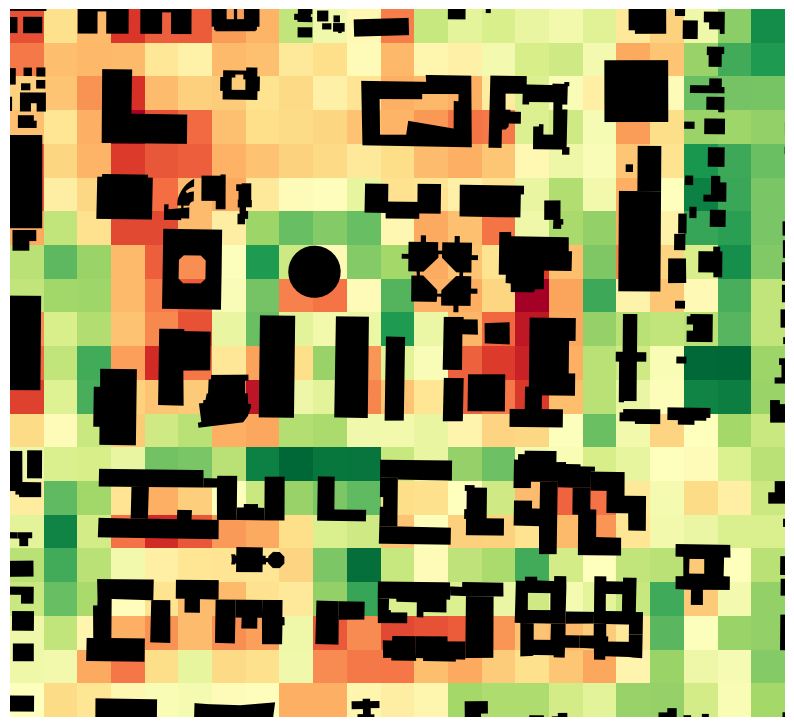

In [15]:
tiff_path = '/Users/braydennoh/Downloads/drive-download-20240525T205321Z-001/NDVI_L7_LowestCloud_2020.tif'

# Open raster file
with rasterio.open(tiff_path) as src:
    print("Raster CRS:", src.crs)

# Convert geometries to raster CRS
buildings = buildings.to_crs(src.crs)
streets_gdf = streets_gdf.to_crs(src.crs)

# Plot raster with buildings
with rasterio.open(tiff_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, cmap='RdYlGn') 
    buildings.plot(ax=ax, color='black', alpha=1)  
    ax.set_xlim([src.bounds.left, src.bounds.right]) 
    ax.set_ylim([src.bounds.bottom, src.bounds.top])  
    plt.axis("off")
    plt.show()

In [5]:
input_path = '/Users/braydennoh/Downloads/drive-download-20240525T205321Z-001/NDVI_L7_LowestCloud_2020.tif'
output_path = '/Users/braydennoh/Downloads/2020NDVI_interpolated.tif'

# Load original NDVI raster
with rasterio.open(input_path) as src:
    ndvi = src.read(1)
    transform = src.transform

    # Increase pixel density
    factor = 3
    ndvi_interpolated = zoom(ndvi, factor, order=3)
    new_transform = rasterio.Affine(transform.a / factor, transform.b, transform.c,
                                    transform.d, transform.e / factor, transform.f)

    # Update metadata
    new_meta = src.meta.copy()
    new_meta.update({
        "height": src.height * factor,
        "width": src.width * factor,
        "transform": new_transform
    })

# Save interpolated NDVI raster
with rasterio.open(output_path, 'w', **new_meta) as dst:
    dst.write(ndvi_interpolated, 1)

In [8]:
# Define paths
input_path = '/Users/braydennoh/Downloads/drive-download-20240525T205321Z-001/NDVI_L7_LowestCloud_2020.tif'
output_path = '/Users/braydennoh/Downloads/2020NDVI_interpolated.tif'

# Load original NDVI raster
with rasterio.open(input_path) as src:
    ndvi = src.read(1)
    transform = src.transform

    # Increase pixel density
    factor = 3
    new_width = src.width * factor
    new_height = src.height * factor

    # Interpolate NDVI data
    ndvi_interpolated = zoom(ndvi, factor, order=3)

    # Adjust transform for new raster dimensions
    new_transform = rasterio.Affine(transform.a / factor, transform.b, transform.c,
                                    transform.d, transform.e / factor, transform.f)

    # Update metadata for new raster
    new_meta = src.meta.copy()
    new_meta.update({
        "driver": "GTiff",
        "height": new_height,
        "width": new_width,
        "transform": new_transform
    })

# Save interpolated NDVI raster
with rasterio.open(output_path, 'w', **new_meta) as dst:
    dst.write(ndvi_interpolated, 1)

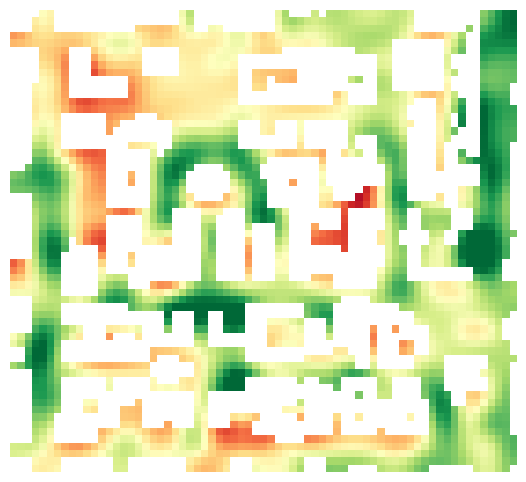

In [14]:
# Path to the interpolated NDVI raster
interpolated_tiff_path = '/Users/braydennoh/Downloads/2020NDVI_interpolated.tif'

# Load the interpolated NDVI raster
with rasterio.open(interpolated_tiff_path) as src:
    ndvi_interpolated = src.read(1)
    interpolated_meta = src.meta

    # Ensure CRS match, if not, reproject buildings
    if buildings.crs != src.crs:
        buildings = buildings.to_crs(src.crs)

    # Create a high-resolution mask of the building areas
    building_mask = rasterize(
        shapes=buildings.geometry,
        out_shape=(src.height, src.width),
        fill=0,
        transform=src.transform,
        all_touched=True,
        default_value=1
    )

    # Apply the mask: set NDVI values to NaN where buildings are located
    ndvi_high_res_masked2020 = np.where(building_mask == 1, np.nan, ndvi_interpolated)

# Display the masked NDVI data with custom colormap
fig, ax = plt.subplots(figsize=(10, 6))
cax = ax.imshow(ndvi_high_res_masked2020, cmap="RdYlGn", vmin=0, vmax=0.5)
plt.axis("off")
plt.show()